# **Introduction to In-Context Learning Demo: Language Conditioned Time Series Prediction**

## **Overview**
In this notebook we show how Large Language Models (LLMs) can **learn and forecast physiological patterns from real-world time-series data** while also taking into account information provided in language form. This experiment uses full-day glucose measurements paired with meal logs to examine how effectively Gemini can internalize meal–glucose dynamics and predict future glucose trajectories. Traditional approaches to blood glucose prediction only take into account numerical data. However, knowing what foods the user take is critical in order to make realistic predictions of the blood glucose levels. **We leverage the fact that ICL uses LLMs in order to incorporate linguistic information about the user's diet into the prediction process**. We also highlight that LLMs already have substantial medical knowledge about glucose levels, Glycemic indeces and the role of diet on healthy bloodsugar levels. The goal is to highlight how an LLM can observe natural daily glucose patterns, understand how meals impact glycemic response, and extend that behavior into an unseen test day.

## **Background**
This demo focuses on real or simulated full-day sequences that include:
- Glucose measurements recorded over the course of a day
- Meal logs that act as the driving input events
- Mentioning the  Glycemic Index (GI) explicitly, so that the LLM infers extra nutritional context

Each daily sequence captures natural dependencies such as meal timing, carbohydrate response, and gradual glucose decay. These sequences form the in-context “training set” that the LLM observes before generating predictions.

What makes this setup particularly interesting:
- The model sees realistic temporal meal–glucose dynamics
- Prompts can include or exclude mention of GI without changing data
- The LLM is never given explicit physiological equations
- The test day requires generalization, not memorization
- Predictions are generated step-by-step (using time points), mimicking real forecasting behavior

This setting offers an intuitive benchmark for understanding whether an LLM can learn biological response patterns simply through context alone.

## **Let's Take a Look at an Example**
The illustration below shows an example of a test day containing glucose readings and meal times. Starting with the beginning of a new day the LLM must forecast. The model receives several complete daily sequences of previous days as examples, each showing how meals shape the glucose curve.

<img src="https://raw.githubusercontent.com/intro-to-icl/intro-to-icl.github.io/refs/heads/master/static/images/glucose_prediction_1.png" height="500">

## **LLM as the Forecaster**

In this demo, we use Gemini 2.0/2.5 Flash in non-reasoning mode, ensuring the model focuses on direct pattern continuation rather than analytical or symbolic interpretation.

The workflow is straightforward:
- Provide several full-day glucose + meal sequences
- Append a future day with partial context
- Ask the model to predict one glucose value at a time
- Iterate until the full sequence is completed

Two prompting strategies are tested:
- Mention of Glycemic Index: The prompt instructs the model to factor in Glycemic Index
- No mention of Glycemic Index: No explicit nutritional guidance is included

The LLM acts as a sequence forecaster—absorbing temporal structure, meal-driven spikes, and recovery patterns from the examples and applying them to the new day.

## **Evaluation**
Finally, we compare these predictions against a Gaussian Process Regression baseline and evaluate performance using RMSE and MSE, providing insight into how well LLMs can approximate physiological patterns through in-context learning alone.

## **Code Overview**
The implementation is organized into a modular structure, with each component responsible for a different stage of the glucose forecasting pipeline. This design separates data preparation, visualization, prompt construction, LLM inference, and performance evaluation, making the system easy to understand, modify, and extend.

## **Before Running the Demo, Follow the Instructions Below**
To run the full experiment:
1. Ensure all dependencies are imported and installed.
2.	Visit Google AI Studio (https://aistudio.google.com/) to obtain your Gemini API key.
3.	Once API key is generated, copy and paste it into the demo when prompted.

#### **If having trouble creating an API Key, follow the link below for instructions:**
* #### **[Instructions on How to Obtain a Gemini API Key](https://docs.google.com/document/d/17pgikIpvZCBgcRh4NNrcee-zp3Id0pU0vq2SG52KIGE/edit?usp=sharing)**

### ***Note: Run all three demos to get comparison results**

In [ ]:
#@title **Import Necessary Libraries**
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from google import genai
from google.genai import types
import re
import itertools
import math
import ast
import os
import getpass
import ipywidgets as widgets
import time

In [ ]:
#@title **Setting Up Gemini Client**
apikey = getpass.getpass("Enter your Gemini API Key: ")
client = genai.Client(api_key=apikey)
comparison_results = {}
config = types.GenerateContentConfig(
    thinking_config=types.ThinkingConfig(
        thinking_budget=0
    )
)

Enter your Gemini API Key: ··········


In [ ]:
#@title **Choose a Model**
model_dropdown = widgets.Dropdown(
    options=[
        ("Gemini 2.5 Flash", "gemini-2.5-flash"),
        ("Gemini 2.0 Flash", "gemini-2.0-flash"),
    ],
    description="Model:",
    value="gemini-2.5-flash",
    style={'description_width': 'initial'}
)

confirm_button = widgets.Button(
    description="Confirm Selection"
)

output = widgets.Output()

model_name = None

def on_confirm_click(b):
    global model_name, batch_size

    model_name = model_dropdown.value

    with output:
        output.clear_output()
        print(f"\nSelected model: {model_name}")

confirm_button.on_click(on_confirm_click)

display(model_dropdown, confirm_button, output)

Dropdown(description='Model:', options=(('Gemini 2.5 Flash', 'gemini-2.5-flash'), ('Gemini 2.0 Flash', 'gemini…

Button(description='Confirm Selection', style=ButtonStyle())

Output()

In [ ]:
#@title **Download Data from GitHub**
if not os.path.exists("intro_to_icl_data"):
    !git clone https://github.com/hsiang-fu/intro_to_icl_data.git

glucose_levels = pd.read_csv("intro_to_icl_data/blood_sugar_data.csv")
food_data = pd.read_csv("intro_to_icl_data/food_data.csv")

Cloning into 'intro_to_icl_data'...
remote: Enumerating objects: 172, done.
remote: Counting objects: 100% (172/172), done.
remote: Compressing objects: 100% (146/146), done.
remote: Total 172 (delta 63), reused 115 (delta 25), pack-reused 0 (from 0)
Receiving objects: 100% (172/172), 17.23 MiB | 23.94 MiB/s, done.
Resolving deltas: 100% (63/63), done.


This cell `Model Inference Function`, is an essential part of this whole demo, it acts as the interface between our program and the language model by sending prompts to the LLM and returning the model’s generated output. Every prompt used throughout the workflow is passed through this function, making it the central mechanism for all model communication.

In [ ]:
#@title **Model Inference Function**
def predict_diabetes_level(prompt):
    response = chat.send_message(prompt)
    return response.text

The two cells below is responsible for running the full interactive glucose-forecasting demo, including user example selection, prompt construction, LLM inference, timeline processing, visualization of predicted vs. expected values, and parsing model outputs. It essentially acts as the end-to-end execution and UI layer of the notebook.

**User Interface**
- The cell provides a simple interface: a user prompt asking how many days of history to include as examples. This makes the demo interactive, allowing users to choose the size of the in-context learning window without modifying any code.

**What the Cell Does**
After the user selects the number of example days, the cell:
1. Builds ICL Training Examples: Formats glucose + food logs from the chosen days into few-shot examples.
2. Constructs the Initial Warm-Up Prompt: Creates a persistent LLM chat session and sends the examples as context.
3. Prepares the Test Data: Loads food and glucose data for the next unseen day.
4. Builds a Timeline: Merges meal events and glucose events into a single chronological sequence.
5. Runs the Prediction Loop: dor each glucose timestamp, the cell determines the relevant meal context, constructs a prediction prompt that incorporates this context along with the glycemic index, sends the prompt to the LLM, and finally parses and stores the model’s predicted glucose value.

**What Each Example Outputs**
A visualization contaning:
- The expected output (Black Curve)
- The LLM-generated output (Red Curve)
- The MSE and RMSE of predicted values

**How Does Example 1 and 2 Differ?**

As mentioned above, we tested two prediction cases for ICL, so:
- **Example 1**: GI-aware, the prompt instructs the model to factor in Glycemic Index
- **Example 2**: GI-agnostic, no explicit nutritional guidance is included

### **Let's Take a Look at an Example of a Prompt:**

**Initial Prompt**
```
You are the world's best glucose level predictor for adults.
Here are some examples of my glucose data for the previous days:
{examples}

*Note: I am not diabetic.
```

This prompt establishes the role of the LLM and provides it with the context needed for in-context learning. By telling the model that it is the “world’s best glucose level predictor,” the prompt sets an expectation that it should focus on accurate forecasting. The following line introduces several example days of glucose data—supplied in place of {examples}—which act as the training demonstrations from which the model learns the underlying patterns of glucose behavior. The note provides the context of the individual.

Then, to predict the individual's forecasted glucose levels, we pass in one of the three versions of these prompt all combined.
```
My last glucose level was {glucose_level} at {previous_time_point}.
```
**plus one of the following:**

Option 1:
```
I just ate ..., ..., ... at {time} on {date}, using the **Glycemic Index** of the meal, predict my glucose level at {next_time point}
```
Option 2:
```
I previously ate at {time} on {date}, infer the **Glycemic Index** values of the meal, predict my glucose level at {next_time point}
```
Option 3:
```
I haven't eaten anything yet, using the **Glycemic Index** of the meal, predict my glucose level at {next_time point}
```
**plus this last section**
```
Output only a Python list with a single dictionary in this format:
[{{'Date': '{target_date}', 'Time': '{t}', 'Blood Sugar Level': value}}]
No extra text, no explanations, no code, only the list.
```
This combined prompt gives the LLM clear situational context (recent glucose level, meal events, and timing) along with strict output formatting instructions, enabling it to generate accurate and consistent predictions for the next time point.


Enter how many days you want to use as examples (e.g. 1-30): 20
Running Prediction Pipeline
Running Iteration 0
Running Iteration 1
Running Iteration 2
Running Iteration 4
Running Iteration 5
Running Iteration 6
Running Iteration 7
Running Iteration 8
Running Iteration 10
Running Iteration 11
Running Iteration 13
Waiting 60 seconds due to quota limits
Rerunning Iteration 13
Running Iteration 14
Running Iteration 15
Mean Squared Error (MSE): 60.69230769230769
Root Mean Squared Error (RMSE): 7.790526791707201


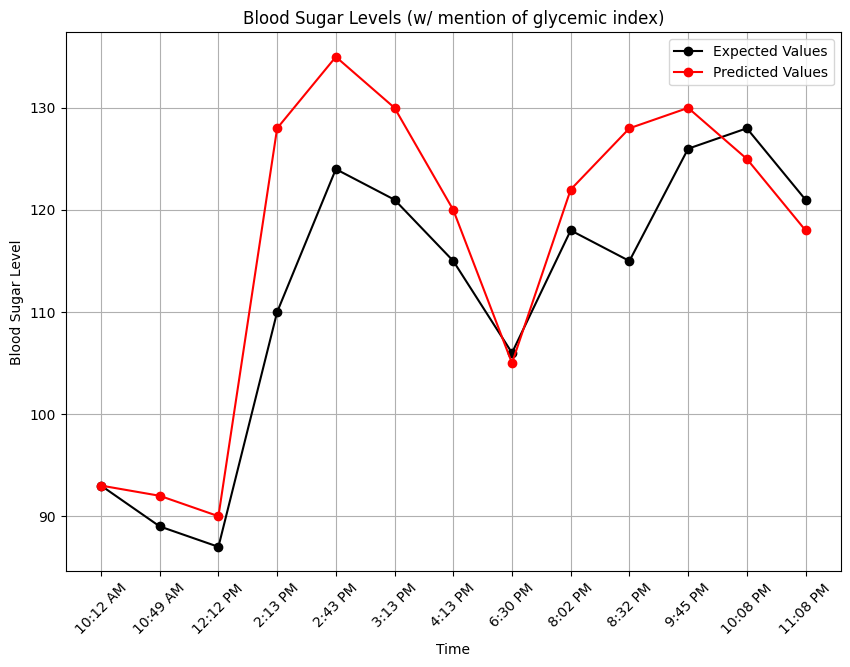

In [ ]:
#@title ## **Example 1: LLM Forecasting w/ mention of the Glycemic Index**
output = []
days_in_example = int(input("Enter how many days you want to use as examples (e.g. 1-30): "))

days = pd.unique(glucose_levels["Date"])[:days_in_example]
examples = [
    f"Here is an example of my glucose level data for {day}:\n"
    f"{glucose_levels.loc[glucose_levels['Date'] == day]}\n"
    f"and examples of the food I consumed at the time:\n"
    f"{food_data.loc[food_data['Date'] == day]}"
    for day in days
]
examples_text = "\n\n".join(examples)

initial_prompt = f"""
        You are the world's best glucose level predictor for adults.
        Here are some examples of my glucose data for the previous days:
        {examples_text}

        *Note: I am not diabetic.
        """

chat = client.chats.create(model=model_name, config=config)

chat.send_message(initial_prompt)

target_date = pd.unique(food_data["Date"])[days_in_example]

target_idx = list(pd.unique(food_data["Date"])).index(target_date)
dates_to_use = pd.unique(food_data["Date"])[target_idx:target_idx+2]
food_date_data = food_data[food_data["Date"].isin(dates_to_use)].copy()

glucose_date_data = glucose_levels[glucose_levels["Date"] == target_date].copy()

meals = food_date_data[["Date", "Time", "Meal Type", "Food Items"]].copy()
meals["Event"] = "Meal"

glucose = glucose_date_data[["Date", "Time", "Blood Sugar Level"]].copy()
glucose["Event"] = "Glucose"

timeline = pd.concat([meals, glucose], ignore_index=True)

timeline["DateTime"] = pd.to_datetime(
    timeline["Date"] + " " + timeline["Time"],
    format="%d-%m-%Y %I:%M %p",
    errors="coerce"
)

timeline = timeline.sort_values("DateTime").reset_index(drop=True)

last_meal = None
previous_context_meal = None
last_context_meal_time = None
current_glucose = glucose_date_data["Blood Sugar Level"].iloc[0]
i = glucose_date_data["Time"].iloc[0]

print(f"Running Prediction Pipeline")
for iteration, row in timeline.iterrows():
    if row["Event"] == "Meal":
        last_meal = row
        continue

    if row["Event"] == "Glucose":
        t = row["Time"]

        # Determine if the last_meal is actually a *new* meal
        if last_meal is not None and last_meal["Time"] != last_context_meal_time:
            # New meal detected
            meal_food = last_meal["Food Items"]
            meal_type = last_meal["Meal Type"]
            meal_time = last_meal["Time"]

            context_meal = f"I just ate {meal_food} at {meal_time}"

            last_context_meal_time = meal_time

        else:
            # No new meal — use "previously ate" logic
            if previous_context_meal and previous_context_meal.startswith("I just ate"):
                context_meal = f"I previously ate a meal at {meal_time}"
            elif previous_context_meal and previous_context_meal.startswith("I previously ate"):
                context_meal = f"I previously ate a meal at {meal_time}"
            else:
                context_meal = "I haven't eaten anything yet."

        previous_context_meal = context_meal


        prompt = f"""
        My last glucose level was {current_glucose} at {i}.
        {context_meal} on {target_date}, infer the **Glycemic Index** values of the meal, predict my glucose level at {t}

        Output only a Python list with a single dictionary in this format:
        [{{'Date': '{target_date}', 'Time': '{t}', 'Blood Sugar Level': value}}]
        No extra text, no explanations, no code, only the list.
        """

        try:
            print(f"Running Iteration {iteration}")
            result = predict_diabetes_level(prompt).replace("`", "").replace("python", "").replace("json", "")
        except Exception as e:
            print("Waiting 60 seconds due to quota limits")
            time.sleep(60)
            print(f"Rerunning Iteration {iteration}")
            result = predict_diabetes_level(prompt).replace("`", "").replace("python", "").replace("json", "")

        try:
            result_list = ast.literal_eval(result.strip())
            output.extend(result_list)
            current_glucose = result_list[-1]["Blood Sugar Level"]
        except Exception as e:
            print("Parsing error:", result, e)

        i = t

df2 = pd.DataFrame(output)

df1 = glucose_levels.loc[glucose_levels['Date'] == target_date]

merged = pd.merge(df1, df2, on="Time", suffixes=("_expected", "_predicted"))

merged["Blood Sugar Level_predicted"] = merged["Blood Sugar Level_predicted"].astype(int)

merged["Error"] = merged["Blood Sugar Level_expected"] - merged["Blood Sugar Level_predicted"]
merged["Absolute Error"] = merged["Error"].abs()
merged["Squared Error"] = merged["Error"] ** 2

mae = merged["Absolute Error"].mean()
mse = merged["Squared Error"].mean()
rmse = np.sqrt(mse)

comparison_results["MSE ICL (w/ mention)"] = mse
comparison_results["RMSE ICL (w/ mention)"] = rmse

print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)

fig, ax1 = plt.subplots(figsize=(10,7))

ax1.plot(merged["Time"], merged["Blood Sugar Level_expected"], label="Expected Values", color = "black", marker="o")
ax1.plot(merged["Time"], merged["Blood Sugar Level_predicted"], label="Predicted Values", color = "red", marker="o")
ax1.set_xlabel("Time")
ax1.set_ylabel("Blood Sugar Level")
ax1.tick_params(axis="x", rotation=45)

lines, labels = ax1.get_legend_handles_labels()

plt.title("Blood Sugar Levels (w/ mention of glycemic index)")
plt.legend()
plt.grid(True)
plt.show()

Enter how many days you want to use as examples (use the same as above): 20
Running Prediction Pipeline
Running Iteration 0
Running Iteration 1
Running Iteration 2
Running Iteration 4
Running Iteration 5
Running Iteration 6
Running Iteration 7
Waiting 60 seconds due to quota limits
Rerunning Iteration 7
Running Iteration 8
Running Iteration 10
Waiting 60 seconds due to quota limits
Rerunning Iteration 10
Running Iteration 11
Running Iteration 13
Waiting 60 seconds due to quota limits
Rerunning Iteration 13
Running Iteration 14
Running Iteration 15
Waiting 60 seconds due to quota limits
Rerunning Iteration 15
Mean Squared Error (MSE): 94.3076923076923
Root Mean Squared Error (RMSE): 9.711214769929265


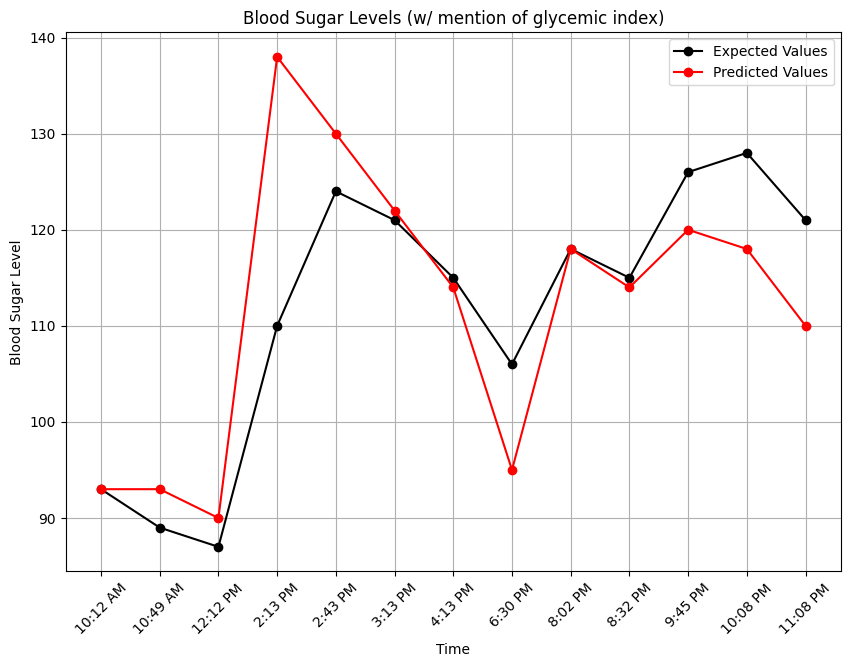

In [ ]:
#@title ## **Example 2: LLM Forecasting w/o mention of the Glycemic Index**
output = []
days_in_example = int(input("Enter how many days you want to use as examples (use the same as above): "))

days = pd.unique(glucose_levels["Date"])[:days_in_example]
examples = [
    f"Here is an example of my glucose level data for {day}:\n"
    f"{glucose_levels.loc[glucose_levels['Date'] == day]}\n"
    f"and examples of the food I consumed at the time:\n"
    f"{food_data.loc[food_data['Date'] == day]}"
    for day in days
]
examples_text = "\n\n".join(examples)

initial_prompt = f"""
        You are the world's best glucose level predictor for adults.
        Here are some examples of my glucose data for the previous days:
        {examples_text}

        *Note: I am not diabetic.
        """

chat = client.chats.create(model=model_name,config=config)

chat.send_message(initial_prompt)

target_date = pd.unique(food_data["Date"])[days_in_example]

target_idx = list(pd.unique(food_data["Date"])).index(target_date)
dates_to_use = pd.unique(food_data["Date"])[target_idx:target_idx+2]
food_date_data = food_data[food_data["Date"].isin(dates_to_use)].copy()

glucose_date_data = glucose_levels[glucose_levels["Date"] == target_date].copy()

meals = food_date_data[["Date", "Time", "Meal Type", "Food Items"]].copy()
meals["Event"] = "Meal"

glucose = glucose_date_data[["Date", "Time", "Blood Sugar Level"]].copy()
glucose["Event"] = "Glucose"

timeline = pd.concat([meals, glucose], ignore_index=True)

timeline["DateTime"] = pd.to_datetime(
    timeline["Date"] + " " + timeline["Time"],
    format="%d-%m-%Y %I:%M %p",
    errors="coerce"
)

timeline = timeline.sort_values("DateTime").reset_index(drop=True)

last_meal = None
previous_context_meal = None
last_context_meal_time = None
current_glucose = glucose_date_data["Blood Sugar Level"].iloc[0]
i = glucose_date_data["Time"].iloc[0]

print(f"Running Prediction Pipeline")
for iteration, row in timeline.iterrows():
    if row["Event"] == "Meal":
        last_meal = row
        continue

    if row["Event"] == "Glucose":
        t = row["Time"]

        # Determine if the last_meal is actually a *new* meal
        if last_meal is not None and last_meal["Time"] != last_context_meal_time:
            # New meal detected
            meal_food = last_meal["Food Items"]
            meal_type = last_meal["Meal Type"]
            meal_time = last_meal["Time"]

            context_meal = f"I just ate {meal_food} at {meal_time}"

            last_context_meal_time = meal_time

        else:
            # No new meal — use "previously ate" logic
            if previous_context_meal and previous_context_meal.startswith("I just ate"):
                context_meal = f"I previously ate a meal at {meal_time}"
            elif previous_context_meal and previous_context_meal.startswith("I previously ate"):
                context_meal = f"I previously ate a meal at {meal_time}"
            else:
                context_meal = "I haven't eaten anything yet."

        previous_context_meal = context_meal


        prompt = f"""
        Here are the examples:
        {examples_text}

        My last glucose level was {current_glucose} at {i}.
        {context_meal} on {target_date}, using the meal, predict my glucose level at {t}

        Output only a Python list with a single dictionary in this format:
        [{{'Date': '{target_date}', 'Time': '{t}', 'Blood Sugar Level': value}}]
        No extra text, no explanations, no code, only the list.
        """

        try:
            print(f"Running Iteration {iteration}")
            result = predict_diabetes_level(prompt).replace("`", "").replace("python", "").replace("json", "")
        except Exception as e:
            print("Waiting 60 seconds due to quota limits")
            time.sleep(60)
            print(f"Rerunning Iteration {iteration}")
            result = predict_diabetes_level(prompt).replace("`", "").replace("python", "").replace("json", "")

        try:
            result_list = ast.literal_eval(result.strip())
            output.extend(result_list)
            current_glucose = result_list[-1]["Blood Sugar Level"]
        except Exception as e:
            print("Parsing error:", result, e)

        i = t

df2 = pd.DataFrame(output)

df1 = glucose_levels.loc[glucose_levels['Date'] == target_date]

merged = pd.merge(df1, df2, on="Time", suffixes=("_expected", "_predicted"))

merged["Blood Sugar Level_predicted"] = merged["Blood Sugar Level_predicted"].astype(int)

merged["Error"] = merged["Blood Sugar Level_expected"] - merged["Blood Sugar Level_predicted"]
merged["Absolute Error"] = merged["Error"].abs()
merged["Squared Error"] = merged["Error"] ** 2

mae = merged["Absolute Error"].mean()
mse = merged["Squared Error"].mean()
rmse = np.sqrt(mse)

comparison_results["MSE ICL (w/o mention)"] = mse
comparison_results["RMSE ICL (w/o mention)"] = rmse

print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)

fig, ax1 = plt.subplots(figsize=(10,7))

ax1.plot(merged["Time"], merged["Blood Sugar Level_expected"], label="Expected Values", color = "black", marker="o")
ax1.plot(merged["Time"], merged["Blood Sugar Level_predicted"], label="Predicted Values", color = "red", marker="o")
ax1.set_xlabel("Time")
ax1.set_ylabel("Blood Sugar Level")
ax1.tick_params(axis="x", rotation=45)

lines, labels = ax1.get_legend_handles_labels()

plt.title("Blood Sugar Levels (w/o mention of glycemic index)")
plt.legend()
plt.grid(True)
plt.show()

This cell `Baseline: Gaussian Process Regression`, implements the baseline model used to benchmark the two in-context learning forecasting approaches. We use a Gaussian Process Regression (GPR) model with a simple DotProduct + WhiteKernel combination to predict glucose levels based on the previous two time steps (lag-1 and lag-2).

After loading and preprocessing the glucose and meal datasets, the code constructs lag features, splits the data into training and test sets, and fits the GPR model.

It then computes overall MSE and RMSE across the full dataset to establish a general performance reference. Next, it isolates the specific day selected for comparison, generates GPR predictions for that day, and evaluates them with day-level MSE and RMSE. Finally, the code visualizes the actual glucose values alongside model predictions and their 95% confidence interval, providing a clear baseline curve to compare against the LLM’s GI-aware and GI-agnostic forecasts.

Enter the same amount of days you entered prior: 20

MSE & RMSE for All Test Cases in the Dataset
Mean Squared Error (MSE): 153.64444291075512
Root Mean Squared Error (RMSE): 12.39533956415697

MSE & RMSE for 2023-11-27
Mean Squared Error (MSE): 177.1674092819684
Root Mean Squared Error (RMSE): 13.310424834766485


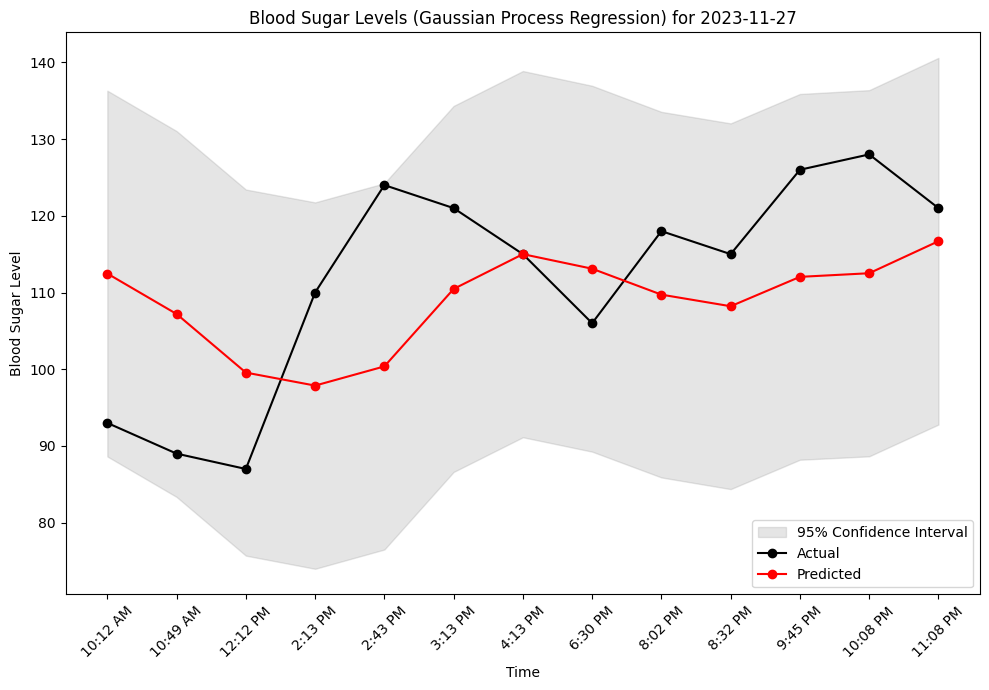

In [ ]:
#@title **Baseline: Gaussian Process Regression**

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

days_before_test = int(input("Enter the same amount of days you entered prior: "))

glucose = pd.read_csv("intro_to_icl_data/blood_sugar_data.csv")
food_data = pd.read_csv("intro_to_icl_data/food_data.csv")

glucose["Date"] = pd.to_datetime(glucose["Date"], format="%d-%m-%Y", errors="coerce")
food_data["Date"] = pd.to_datetime(food_data["Date"], format="%d-%m-%Y", errors="coerce")

glucose["glucose_lag1"] = glucose["Blood Sugar Level"].shift(1)
glucose["glucose_lag2"] = glucose["Blood Sugar Level"].shift(2)
glucose = glucose.dropna()

X = glucose[["glucose_lag1", "glucose_lag2"]]
y = glucose["Blood Sugar Level"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

kernel = DotProduct() + WhiteKernel()
gpr = GaussianProcessRegressor(kernel=kernel, random_state=0)
gpr.fit(X_train, y_train)

preds, stds = gpr.predict(X_test, return_std=True)

mse = mean_squared_error(y_test, preds)
rmse = np.sqrt(mse)

print("\nMSE & RMSE for All Test Cases in the Dataset")
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)

one_day = pd.unique(food_data["Date"])[days_before_test]
day_data = glucose[glucose["Date"] == one_day].copy()

if not day_data.empty:
    date_str = pd.Timestamp(one_day).strftime('%Y-%m-%d')
    day_data["Predicted"], day_data["Std"] = gpr.predict(day_data[["glucose_lag1", "glucose_lag2"]], return_std=True)

    mse = mean_squared_error(day_data["Blood Sugar Level"], day_data["Predicted"])
    rmse = np.sqrt(mse)

    comparison_results["MSE Baseline"] = mse
    comparison_results["RMSE Baseline"] = rmse

    print(f"\nMSE & RMSE for {date_str}")
    print("Mean Squared Error (MSE):", mse)
    print("Root Mean Squared Error (RMSE):", rmse)

    day_data["Lower"] = day_data["Predicted"] - 1.96 * day_data["Std"]
    day_data["Upper"] = day_data["Predicted"] + 1.96 * day_data["Std"]

    plt.figure(figsize=(10,7))
    x_axis = day_data["Time"] if "Time" in day_data.columns else day_data["Date"].dt.strftime("%H:%M")

    plt.fill_between(x_axis, day_data["Lower"], day_data["Upper"], alpha=0.2, color='gray', label='95% Confidence Interval')
    plt.plot(x_axis, day_data["Blood Sugar Level"], color="black", label="Actual", marker='o')
    plt.plot(x_axis, day_data["Predicted"], color="red", label="Predicted", marker='o')


    date_str = pd.Timestamp(one_day).strftime('%Y-%m-%d')
    plt.title(f"Blood Sugar Levels (Gaussian Process Regression) for {date_str}")
    plt.xlabel("Time")
    plt.ylabel("Blood Sugar Level")
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

### **Before Running This Section, make sure you have already ran all three demos:**
	1.	ICL w/ mention of glycemic index (Example 1)
	2.	ICL w/o mention of glycemic index (Example 2)
	3.	Gaussian Process Regression (GPR) (Baseline)

This cell `Comparison`, brings together the results from all three forecasting approaches: the GI-aware ICL version, the GI-agnostic ICL version, and the GPR baseline to provide a direct performance comparison.

This plot highlights how each approach performs relative to the others, making it easy to see the impact of including GI information and how both LLM-based methods compare to the traditional GPR baseline.

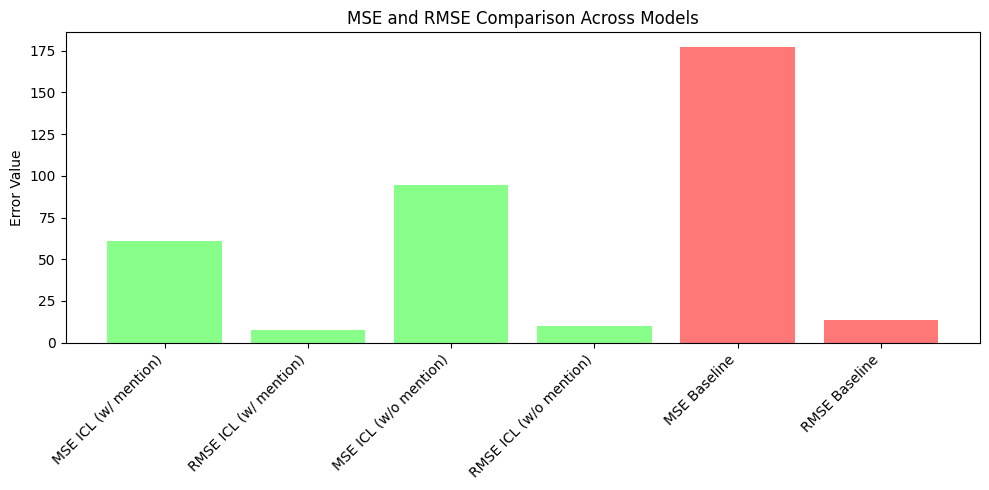

In [ ]:
#@title **Comparison Results**
keys = list(comparison_results.keys())
values = [float(v) for v in comparison_results.values()]

colors = ["#FF7777" if "Baseline" in k else "#88FF88" for k in keys]

plt.figure(figsize=(10, 5))
bars = plt.bar(keys, values, color=colors)

plt.xticks(rotation=45, ha='right')
plt.ylabel("Error Value")
plt.title("MSE and RMSE Comparison Across Models")

plt.tight_layout()
plt.show()

## **Summary**

This demo illustrates how LLMs can perform ICL to forecast physiological time-series data, using daily glucose measurements paired with meal events as the foundation. By providing the model with several full-day examples, we show that it can internalize natural glycemic patterns—such as post-meal spikes and gradual return to baseline—and extend them to generate predictions for an unseen future day.

We explore two prompting strategies for predicting glucose levels. In the first strategy, the prompt explicitly instructs the model to infer GI values when generating its outputs. In the second strategy, the prompt provides only the input line, without mentioning GI at all, leaving the model to independently determine what information to extract and how to contextualize it. Comparing these two approaches allows us to analyze how the LLM’s outputs differ, how the presence or absence of explicit guidance shapes its reasoning process

Alongside the two LLM-based approaches, we also construct a Gaussian Process Regression (GPR) baseline using traditional time-series lag features, providing a grounded benchmark for assessing the strengths and limitations of in-context learning in this setting. When compared against this baseline, both the ICL approach that explicitly incorporates the guidance for using the Glycemic Index and withut the GI guidance performs the best—capturing meaningful glucose trends and achieving the lowest MSE and RMSE values. On the other hand, while the baseline model achieves relatively average/similar error, it fails to reproduce realistic temporal patterns shown in the graph, instead relying strictly on short-term lag structure.

The same methodology demonstrated here can be extended beyond glucose forecasting to a wide range of physiological and behavioral time-series tasks. By curating a small number of representative examples, LLMs can be prompted to learn patterns related to circadian rhythms, activity cycles, medication effects, or other temporal health signals. These extensions highlight the flexibility of in-context learning when applied to structured real-world sequences, opening the door to rapid pattern generalization without the need for explicit mechanistic models.

## **Conclusion**

This demonstration shows that LLMs can generalize temporal patterns in a way that resembles human intuition—capturing meal-driven glucose dynamics from only a handful of daily examples. Even without explicit physiological equations, the model can infer relationships between meals and glucose responses and apply them to forecast an entire future day. While the LLM does not perform mechanistic or medical reasoning, its ability to approximate nonlinear biological behavior through pattern recognition underscores the potential of in-context learning for health-related time-series tasks. Comparing the LLM’s predictions to a GPR baseline further reveals where LLMs excel and where traditional models remain competitive, offering a balanced perspective on the opportunities and limitations of treating LLMs as general sequence pattern learners.